# Разработка системы распознавания предметов интерьера в потоковом видео

## Часть 2: Выявление частоты классов в датасете

In [1]:
%matplotlib inline

#System
import os
import shutil
import random

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from skimage.io import imread, imshow

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

In [2]:
from scripts_.PathFinder import PathFinder
from scripts_.SegEncoder import SegEncoder
from scripts_.ClassList import ClassList

pf = PathFinder()
se = SegEncoder()

img_dir = 'data/ADE20K_filtred/images/'

### 1. Класс для работы с данными

Напишем класс для работы с данными

Выделим все объекты из папки, сортируем их по количествую вхождений, установив порог для минимального числа вхождений

In [3]:
%%time
cl = ClassList(img_dir, min_obj=50, progress_step=500)

Size: 7166
Done: 500
Done: 1000
Done: 1500
Done: 2000
Done: 2500
Done: 3000
Done: 3500
Done: 4000
Done: 4500
Done: 5000
Done: 5500
Done: 6000
Done: 6500
Done: 7000
CPU times: user 3min 38s, sys: 31.3 s, total: 4min 9s
Wall time: 4min 11s


In [4]:
cl.class_list

[['-'],
 ['wall'],
 ['chair'],
 ['floor, flooring'],
 ['painting, picture'],
 ['cabinet'],
 ['windowpane, window'],
 ['table'],
 ['light, light source'],
 ['ceiling'],
 ['lamp'],
 ['cushion'],
 ['curtain, drape, drapery, mantle, pall'],
 ['book'],
 ['door'],
 ['plant, flora, plant life'],
 ['bed'],
 ['pillow'],
 ['armchair'],
 ['bottle'],
 ['person, individual, someone, somebody, mortal, soul'],
 ['vase'],
 ['box'],
 ['sofa, couch, lounge'],
 ['wall socket, wall plug, electric outlet, electrical outlet, outlet, electric receptacle'],
 ['shelf'],
 ['flower'],
 ['plate'],
 ['glass, drinking glass'],
 ['rug, carpet, carpeting'],
 ['sink'],
 ['sconce'],
 ['mirror'],
 ['pot, flowerpot'],
 ['work surface'],
 ['towel'],
 ['desk'],
 ['swivel chair'],
 ['coffee table, cocktail table'],
 ['bowl'],
 ['plaything, toy'],
 ['basket, handbasket'],
 ['pot'],
 ['candlestick, candle holder'],
 ['stool'],
 ['switch, electric switch, electrical switch'],
 ['chest of drawers, chest, bureau, dresser'],
 ['t

In [5]:
cl.size()

193

### 2. Удаление лишних классов

In [6]:
rm_class_list = []


#слишком частые классы
rm_class_list.append("wall")
rm_class_list.append("floor, flooring")
rm_class_list.append("ceiling")


#слишком сложные классы
rm_class_list.append("windowpane, window")
rm_class_list.append("box")
rm_class_list.append("mirror")
rm_class_list.append("basket, handbasket")
rm_class_list.append("blind, screen")
rm_class_list.append("spotlight, spot")
rm_class_list.append("railing, rail")
rm_class_list.append("seat")
rm_class_list.append("doorframe, doorcase")
rm_class_list.append("screen door, screen")
rm_class_list.append("beam")
rm_class_list.append("grill, grille, grillwork")
rm_class_list.append("rod")
rm_class_list.append("sky")
rm_class_list.append("rack")
rm_class_list.append("pane, pane of glass, window glass")
rm_class_list.append("shutter")
rm_class_list.append("machine")
rm_class_list.append("skylight, fanlight")
rm_class_list.append("piano, pianoforte, forte-piano")                    
rm_class_list.append("fireplace, hearth, open fireplace")
rm_class_list.append("double door")
rm_class_list.append("heater, warmer")
rm_class_list.append("chest")
rm_class_list.append("paper")
rm_class_list.append("document, written document, papers")
rm_class_list.append("notebook")
rm_class_list.append("booklet, brochure, folder, leaflet, pamphlet")
rm_class_list.append("board, plank")
rm_class_list.append("teapot")
rm_class_list.append("bannister, banister, balustrade, balusters, handrail")
rm_class_list.append("vent, venthole, vent-hole, blowhole")
rm_class_list.append("toaster")
rm_class_list.append("bulletin board, notice board")
rm_class_list.append("microphone, mike")
rm_class_list.append("partition, divider")
rm_class_list.append('ottoman, pouf, pouffe, puff, hassock')
rm_class_list.append('blanket, cover')
rm_class_list.append('shower')
rm_class_list.append('step, stair')
rm_class_list.append("bar")
rm_class_list.append('booth, cubicle, stall, kiosk')
rm_class_list.append('screen, silver screen, projection screen')
rm_class_list.append('shower stall, shower bath')
rm_class_list.append('eiderdown, duvet, continental quilt')
rm_class_list.append('poster, posting, placard, notice, bill, card')
rm_class_list.append("buffet, counter, sideboard")
rm_class_list.append('drawer')
rm_class_list.append('fluorescent, fluorescent fixture')
rm_class_list.append('faucet, spigot')


#бесполезные
rm_class_list.append('curtain, drape, drapery, mantle, pall')
rm_class_list.append("bottle")
rm_class_list.append("plate")
rm_class_list.append("glass, drinking glass")
rm_class_list.append("towel")
rm_class_list.append("bowl")
rm_class_list.append("plaything, toy")
rm_class_list.append("column, pillar")
rm_class_list.append("figurine, statuette")
rm_class_list.append("tray")
rm_class_list.append("jar")
rm_class_list.append("fruit")
rm_class_list.append("mug")
rm_class_list.append("pool ball")
rm_class_list.append("pool table, billiard table, snooker table")
rm_class_list.append("bag")
rm_class_list.append("pitcher, ewer")
rm_class_list.append("cup")
rm_class_list.append("bucket, pail")
rm_class_list.append("knife")
rm_class_list.append("ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin")
rm_class_list.append("tree")
rm_class_list.append("can, tin, tin can")
rm_class_list.append("sculpture")
rm_class_list.append("cue, cue stick, pool cue, pool stick")
rm_class_list.append("soap dispenser")
rm_class_list.append("teacup")
rm_class_list.append("food, solid food")
rm_class_list.append("pottery, clayware")
rm_class_list.append("arcade machine")
rm_class_list.append("ball")
rm_class_list.append("hanger")
rm_class_list.append("towel rack, towel horse")
rm_class_list.append("soap")
rm_class_list.append("bouquet, corsage, posy, nosegay")
rm_class_list.append("canister, cannister, tin")
rm_class_list.append("bag, handbag, pocketbook, purse")
rm_class_list.append("fork")
rm_class_list.append("pipe, pipage, piping")
rm_class_list.append("saucepan")
rm_class_list.append("soap dish")
rm_class_list.append("ashtray")
rm_class_list.append("bag, traveling bag, travelling bag, grip, suitcase")
rm_class_list.append("building, edifice")
rm_class_list.append("spoon")
rm_class_list.append("coffee cup")
rm_class_list.append("backpack, back pack, knapsack, packsack, rucksack, haversack")
rm_class_list.append("vase")
rm_class_list.append("pot, flowerpot")
rm_class_list.append("pot")
rm_class_list.append("chandelier, pendant, pendent")
rm_class_list.append("shoe")
rm_class_list.append("toilet tissue, toilet paper, bathroom tissue")
rm_class_list.append("signboard, sign")
rm_class_list.append("dishrag, dishcloth")
rm_class_list.append("paper towel")
rm_class_list.append("hat, chapeau, lid")
rm_class_list.append('napkin, table napkin, serviette')
rm_class_list.append('place mat')


#мало пикселей
rm_class_list.append("wall socket, wall plug, electric outlet, electrical outlet, outlet, electric receptacle")
rm_class_list.append("sconce")
rm_class_list.append("candlestick, candle holder")
rm_class_list.append("switch, electric switch, electrical switch")
rm_class_list.append("telephone, phone, telephone set")
rm_class_list.append("candle, taper, wax light")
rm_class_list.append("pen")
rm_class_list.append("remote control, remote")
rm_class_list.append("candelabrum, candelabra")
rm_class_list.append("spectacles, specs, eyeglasses, glasses")
rm_class_list.append("light bulb, lightbulb, bulb, incandescent lamp, electric light, electric-light bulb")
rm_class_list.append('light, light source')


#уменьшение датасета
rm_class_list.append('clock')
rm_class_list.append('mousepad, mouse mat')
rm_class_list.append('keyboard')
rm_class_list.append('lamp')
rm_class_list.append('book')
rm_class_list.append("magazine")
rm_class_list.append('shelf')
rm_class_list.append('bookcase')
rm_class_list.append('flower')
rm_class_list.append('coffee maker')
rm_class_list.append("kettle, boiler")
rm_class_list.append('system')
rm_class_list.append('stairs, steps')
rm_class_list.append('air conditioner, air conditioning')
rm_class_list.append('radiator')
rm_class_list.append('fan')
rm_class_list.append('dishwasher, dish washer, dishwashing machine')
rm_class_list.append('loudspeaker, speaker, speaker unit, loudspeaker system, speaker system')
rm_class_list.append('coffee table, cocktail table')
rm_class_list.append('cradle')
rm_class_list.append('toilet, can, commode, crapper, pot, potty, stool, throne')
rm_class_list.append('bench')
rm_class_list.append('blackboard, chalkboard')

#одежда
rm_class_list.append('apparel, wearing apparel, dress, clothes')
rm_class_list.append('shirt')
rm_class_list.append('trouser, pant')
rm_class_list.append('jacket')
rm_class_list.append('sweater, jumper')
rm_class_list.append('stairway, staircase')

#сокращение выборки
rm_class_list.append("stool")
rm_class_list.append('console table, console')
rm_class_list.append('laptop, laptop computer')
rm_class_list.append('refrigerator, icebox')
rm_class_list.append('microwave, microwave oven')
rm_class_list.append('oven')
rm_class_list.append('hood, exhaust hood')
rm_class_list.append('printer')
rm_class_list.append('person, individual, someone, somebody, mortal, soul')

In [7]:
cl.remove_classes(rm_class_list)

[]

In [8]:
cl.size()

31

### 3. Объединение классов

In [9]:
jo_class_list = []

jo_class_list.append(['drawing', 'painting, picture'])
jo_class_list.append(['tapestry, tapis', 'painting, picture'])

jo_class_list.append(['desk', 'table'])

jo_class_list.append(['work surface', 'counter'])
jo_class_list.append(['kitchen island', 'counter'])
jo_class_list.append(['countertop', 'counter'])

jo_class_list.append(['television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box' , 'monitor, monitoring device'])
jo_class_list.append(['screen, crt screen' , 'monitor, monitoring device'])
jo_class_list.append(['computer, computing machine, computing device, data processor, electronic computer, information processing system' , 'monitor, monitoring device'])

jo_class_list.append(['swivel chair', 'chair'])

jo_class_list.append(['wardrobe, closet, press', "cabinet"])

jo_class_list.append(['sofa, couch, lounge', "bed"])
jo_class_list.append(['cushion', "bed"])
jo_class_list.append(['pillow', "bed"])

In [10]:
flat = []
for megaclass in jo_class_list:
    for class_name in megaclass:
        if class_name not in flat:
            flat.append(class_name)

In [11]:
cl.join_list(jo_class_list)

[]

In [12]:
cl.size()

17

In [13]:
cl.class_list

[['-'],
 ['chair', 'swivel chair'],
 ['painting, picture', 'drawing', 'tapestry, tapis'],
 ['cabinet', 'wardrobe, closet, press'],
 ['table', 'desk'],
 ['door'],
 ['plant, flora, plant life'],
 ['bed', 'sofa, couch, lounge', 'cushion', 'pillow'],
 ['armchair'],
 ['rug, carpet, carpeting'],
 ['sink'],
 ['chest of drawers, chest, bureau, dresser'],
 ['stove, kitchen stove, range, kitchen range, cooking stove'],
 ['bathtub, bathing tub, bath, tub'],
 ['monitor, monitoring device',
  'television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box',
  'screen, crt screen',
  'computer, computing machine, computing device, data processor, electronic computer, information processing system'],
 ['counter', 'work surface', 'kitchen island', 'countertop'],
 ['washer, automatic washer, washing machine']]

### Визуализация предметов

In [16]:
def get_flatten_class_list():
    flat = []
    for megaclass in cl.class_list:
        for class_name in megaclass:
            flat.append(class_name)
            
    return flat

In [17]:
cl_flat = get_flatten_class_list()
cl_flat.remove('-')

In [18]:
for class_name, i in zip(cl_flat, range(20)):
    print(class_name)
print("...")

wall
chair
floor, flooring
painting, picture
cabinet
windowpane, window
table
light, light source
ceiling
lamp
cushion
curtain, drape, drapery, mantle, pall
book
door
plant, flora, plant life
bed
pillow
armchair
bottle
person, individual, someone, somebody, mortal, soul
...


In [19]:
len(cl_flat)

192

In [37]:
%%time
hw_all = se.get_hw_dict(dir_path=img_dir, class_list=jo_flat,
                        max_num=3, skip_probably=0.5, progress_bar=True)

Done: 1
0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 1; 0; 0; 0; 
Done: 3
0; 0; 0; 0; 1; 0; 0; 0; 0; 0; 1; 0; 0; 0; 
Done: 4
0; 1; 0; 0; 1; 0; 0; 0; 0; 0; 1; 0; 0; 0; 
Done: 5
0; 1; 0; 0; 2; 0; 0; 0; 0; 0; 1; 0; 0; 0; 
Done: 6
0; 2; 0; 1; 2; 0; 0; 0; 0; 0; 1; 1; 0; 0; 
Done: 7
0; 2; 0; 1; 3; 0; 0; 0; 0; 0; 1; 1; 0; 0; 
Done: 8
0; 2; 0; 2; 3; 0; 0; 0; 0; 0; 1; 1; 0; 0; 
Done: 9
0; 3; 0; 3; 4; 0; 0; 0; 0; 0; 1; 2; 0; 0; 
Done: 37
0; 3; 1; 3; 4; 0; 0; 0; 0; 0; 1; 2; 0; 0; 
Done: 54
0; 4; 2; 3; 4; 0; 0; 0; 0; 0; 1; 2; 0; 0; 
Done: 57
0; 4; 2; 3; 4; 0; 0; 0; 1; 0; 1; 2; 0; 0; 
Done: 58
0; 5; 2; 3; 4; 0; 0; 0; 1; 0; 1; 3; 0; 0; 
Done: 59
0; 6; 2; 3; 4; 1; 0; 0; 1; 0; 1; 3; 0; 0; 
Done: 60
0; 6; 2; 3; 5; 1; 0; 0; 2; 0; 1; 3; 0; 0; 
Done: 62
0; 6; 2; 3; 5; 1; 0; 1; 2; 0; 1; 3; 0; 0; 
Done: 64
0; 6; 2; 3; 5; 2; 0; 1; 2; 0; 1; 3; 0; 0; 
Done: 65
0; 7; 2; 3; 6; 2; 0; 2; 2; 0; 1; 3; 0; 0; 
Done: 66
0; 7; 2; 3; 6; 2; 0; 3; 2; 0; 1; 3; 0; 0; 
Done: 71
0; 7; 2; 3; 7; 2; 0; 4; 2; 1; 1; 3; 0; 0; 
Done: 73
0; 7; 2; 3;

drawing


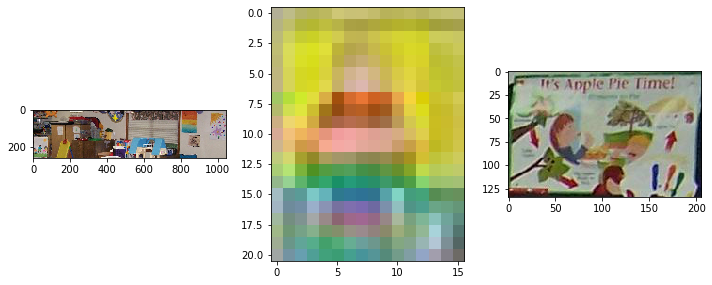

painting, picture


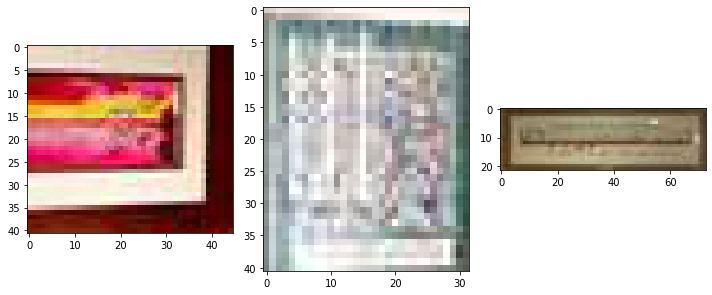

tapestry, tapis


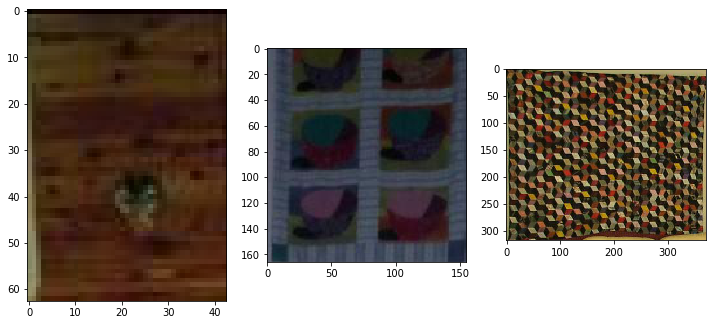

desk


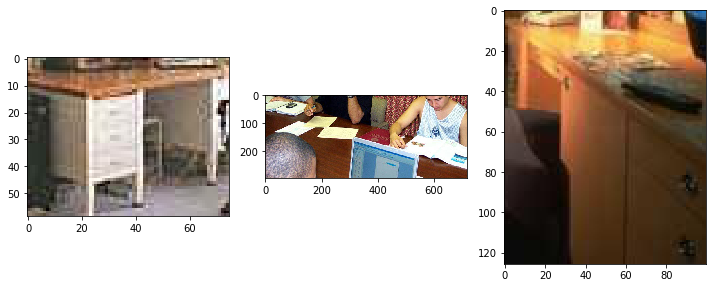

table


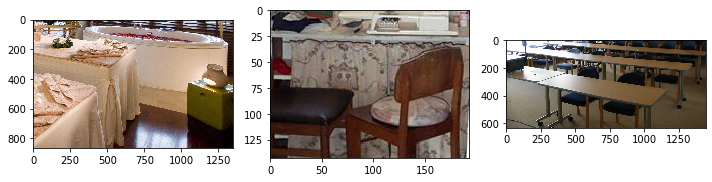

cushion


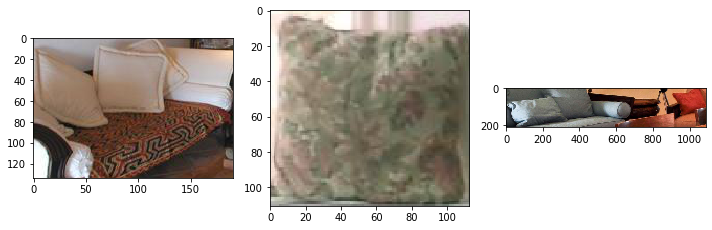

pillow


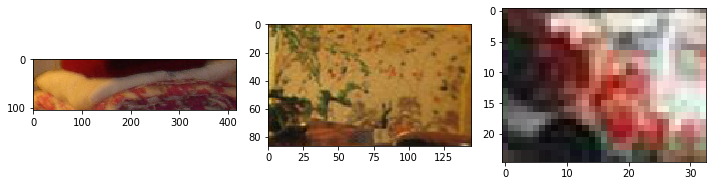

work surface


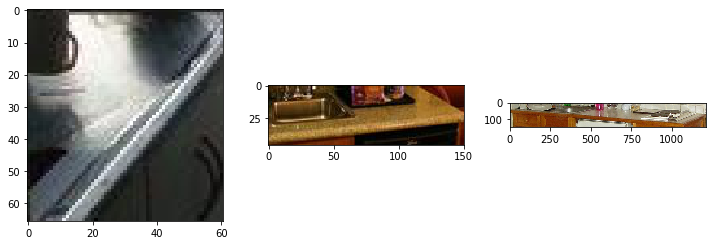

counter


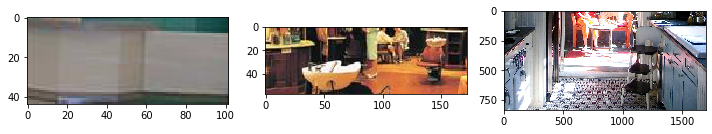

kitchen island


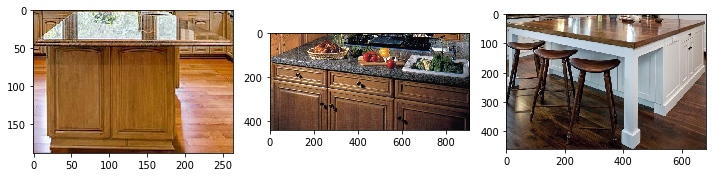

countertop


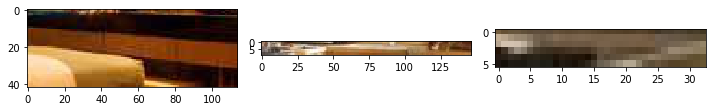

television receiver, television, television set, tv, tv set, idiot box, boob tube, telly, goggle box


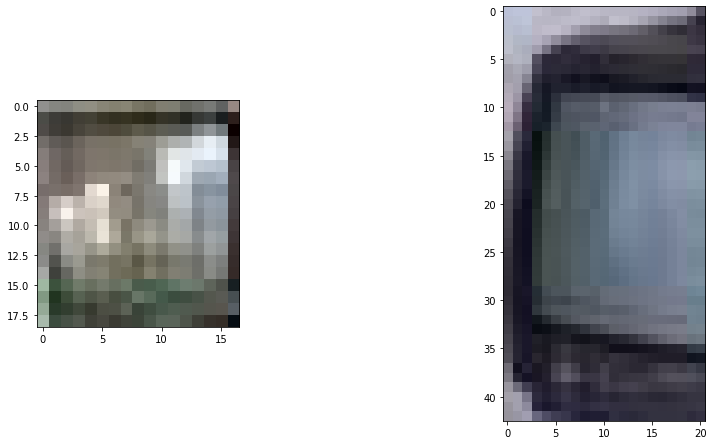

monitor, monitoring device


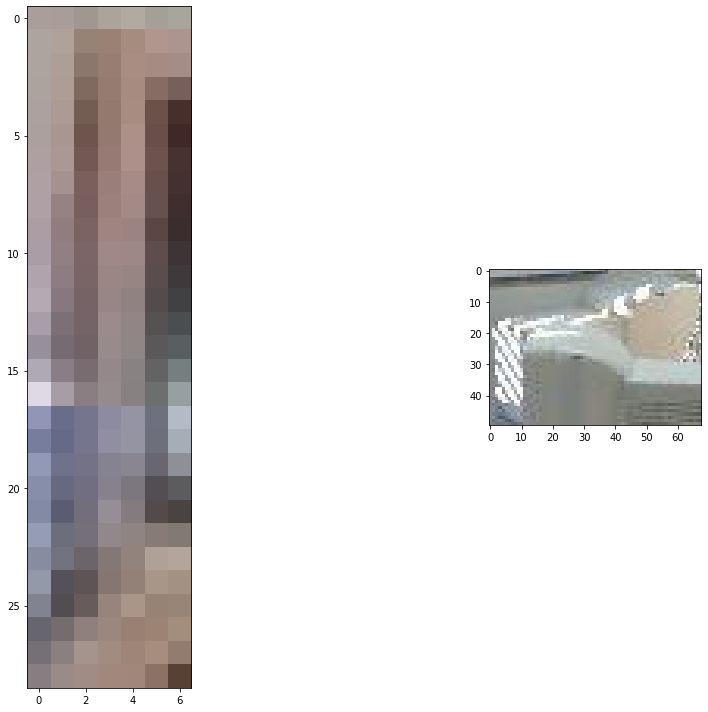

screen, crt screen


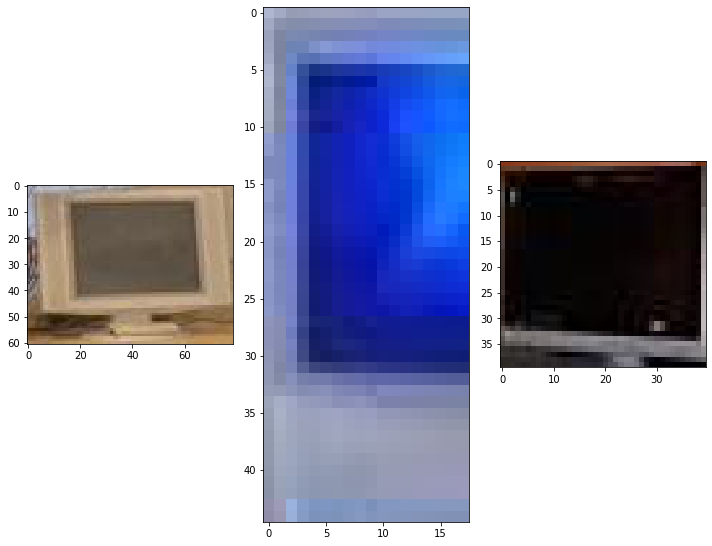

Text(0.5, 1.0, 'wall socket')

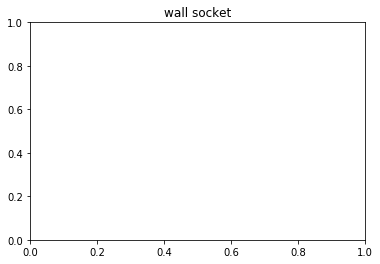

In [38]:
se.show(hw_all, jo_flat, subplot_num=3)
plt.title("wall socket")

### Сохранение

In [14]:
cl.save_class_list('static/class_list.txt')

### 4. Совмещение с индексами классов

Запишем правила перекодирования классов в файл

In [15]:
cl.save_class_encode('static/class_encode.txt')